<a href="https://colab.research.google.com/github/obekparovo/MSc-BDA-Artefact/blob/main/M_ScMaths_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic Nigerian traffic data...

Training Vanilla ST-GCN...
  Epoch 0: Loss = 550.3049
  Epoch 5: Loss = 603.1543
  Epoch 10: Loss = 710.3972
  Epoch 15: Loss = 155.7540

Training DPGL-ST-GCN...
  Epoch 0: Loss = 582.5886
  Epoch 5: Loss = 580.2797
  Epoch 10: Loss = 586.6082
  Epoch 15: Loss = 96.8139

Evaluating models on test set...

MODEL PERFORMANCE COMPARISON (Nigerian Synthetic Data)
Metric       ST-GCN (Vanilla)     DPGL-ST-GCN (Ours)  
------------------------------------------------------------
RMSE         6.2899               4.6233              
MAE          3.1496               2.3078              
MAPE (%)     1023105728.00        1444838016.00       


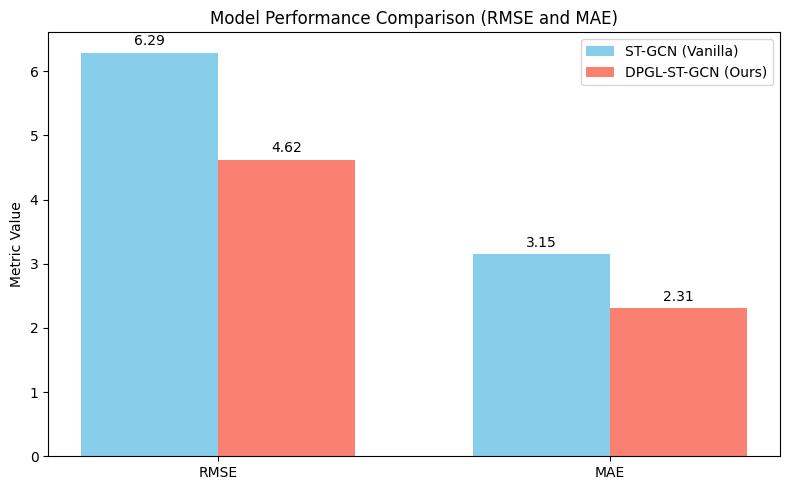

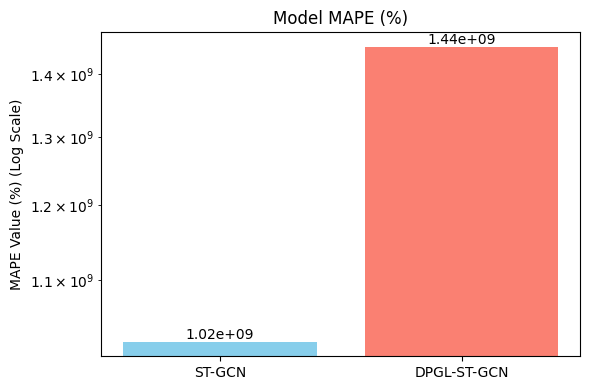

In [5]:
# Chapter 4: Experimental Validation of DPGL-ST-GCN
# Author: Solomon Ejasę-Tobrisę Udele
#Matric. Num:- PG/PSC9103868
# Date: November 2025

import torch
import torch.nn as nn
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F  # F = torch.nn.functional
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ----------------------------
# 1. Synthetic Nigerian Data Generator
# ----------------------------
def generate_nigerian_traffic_data(N=100, T=2000, H=6, p_obs=0.2):
    """
    Generate synthetic traffic data mimicking Nigerian conditions:
    - Dynamic edge closures (5-15% per step)
    - Sparse node observations (p_obs = 0.1-0.3)
    - Non-stationary travel times

    Returns: X_true (T, N, F), X_obs (T, N, F), A_base (N, N), A_dynamic (T, N, N)
    """
    np.random.seed(42)
    torch.manual_seed(42)

    # Base graph: grid + random hubs (Lagos-like)
    A_base = np.zeros((N, N))
    grid_size = int(np.sqrt(N))
    for i in range(N):
        for j in range(N):
            if i == j: continue
            # Grid neighbors
            if (abs(i//grid_size - j//grid_size) + abs(i%grid_size - j%grid_size)) <= 1:
                A_base[i, j] = 1
    # Add hub connections
    hubs = np.random.choice(N, size=5, replace=False)
    for h in hubs:
        for i in range(N):
            if h != i and np.random.rand() < 0.1:
                A_base[h, i] = 1
                A_base[i, h] = 1
    A_base = ((A_base + A_base.T) > 0).astype(int) # Ensure symmetry

    # Initialise true states
    X_true = np.zeros((T, N, 4))  # [speed, occ, rain, incident]
    X_true[0, :, 0] = 30 + 10*np.random.rand(N) # Initial speed
    X_true[0, :, 1] = 0.3 + 0.1*np.random.rand(N) # Initial occupancy
    A_dynamic = np.zeros((T, N, N))
    A_dynamic[0] = A_base.copy()

    for t in range(1, T):
        # Dynamic edge failures
        A_dynamic[t] = A_dynamic[t-1].copy()
        block_prob = np.random.uniform(0.05, 0.15)
        # Randomly block some base edges
        for i in range(N):
            for j in range(i + 1, N):
                if A_base[i, j] == 1 and np.random.rand() < block_prob:
                    A_dynamic[t, i, j] = 0
                    A_dynamic[t, j, i] = 0

        # Ground truth features via diffusion
        speed_prev = X_true[t-1, :, 0]
        occ_prev = X_true[t-1, :, 1]

        # Diffusion (weighted average of neighbors + self-loop)
        A_t_with_self = A_dynamic[t] + np.eye(N)
        D_t_inv = np.diag(1.0 / np.sum(A_t_with_self, axis=1))
        Norm_A = D_t_inv @ A_t_with_self

        # New speed/occ is a smooth function of previous values
        X_true[t, :, 0] = Norm_A @ speed_prev * (0.9 + 0.2*np.random.rand())
        X_true[t, :, 1] = np.clip(Norm_A @ occ_prev + 0.05*np.random.randn(N), 0.1, 1.0)

        # Add exogenous factors
        X_true[t, :, 2] = np.random.exponential(0.5)  # rainfall (mm/hr)
        incident_rate = 0.02
        X_true[t, :, 3] = (np.random.rand(N) < incident_rate).astype(float)

    # Create sparse observed data
    X_obs = np.full_like(X_true, np.nan)
    for t in range(T):
        obs_mask = np.random.rand(N, 4) < p_obs
        X_obs[t][obs_mask] = X_true[t][obs_mask]

    return X_true, X_obs, A_base, A_dynamic

# ----------------------------
# 2. Vanilla ST-GCN (Yu et al., 2018)
# ----------------------------
class STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, out_channels, horizon, adj_matrix):
        super(STGCN, self).__init__()
        self.num_nodes = num_nodes
        self.horizon = horizon
        self.out_channels = out_channels

        # Calculate normalized adjacency for GCNConv only once
        adj = torch.tensor(adj_matrix, dtype=torch.float32)
        adj = adj + torch.eye(num_nodes)

        # Store edge_index for PyG GCNConv
        self.register_buffer('edge_index', adj.nonzero().t().contiguous())

        self.gcn1 = GCNConv(in_channels, 64, normalize=True)
        self.gcn2 = GCNConv(64, 32, normalize=True)

        # Fixed Conv1D: kernel 7, padding 0 maps seq_len=12 to horizon=6
        self.temporal = nn.Conv1d(32, out_channels, kernel_size=7, padding=0)

    def forward(self, x):
        # x: [batch, seq_len, N, F]
        batch, seq_len, N, F_feat = x.shape

        # Spatial GCN (Per-timestep)
        x_out = []
        for t in range(seq_len):
            x_t = x[:, t, :, :] # [batch, N, F]
            x_t_out = []
            for b in range(batch):
                node_features = x_t[b] # [N, F]
                # Apply GCN layers using the static edge index
                h = F.relu(self.gcn1(node_features, self.edge_index))
                h = self.gcn2(h, self.edge_index) # [N, 32]
                x_t_out.append(h)
            x_out.append(torch.stack(x_t_out, dim=0)) # [batch, N, 32]

        x_out = torch.stack(x_out, dim=1) # [batch, seq_len, N, 32]

        # Temporal convolution
        # Correct reshape for Conv1D: [B * N, features_gcn, seq_len]
        x_out = x_out.permute(0, 2, 3, 1) # [batch, N, 32, seq_len]
        x_out = x_out.reshape(batch * N, 32, seq_len)

        x_out = self.temporal(x_out)  # [B * N, F, H] (e.g., [1600, 4, 6])

        # Reshape to [batch, N, F, H]
        x_out = x_out.view(batch, N, self.out_channels, self.horizon)

        # Final output shape: [batch, H, N, F]
        return x_out.permute(0, 3, 1, 2)

# ----------------------------
# 3. DPGL-ST-GCN (Our Model)
# ----------------------------
class DPGL_STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, out_channels, horizon, base_adj):
        super(DPGL_STGCN, self).__init__()
        self.num_nodes = num_nodes
        self.horizon = horizon
        self.out_channels = out_channels
        self.register_buffer('base_adj', torch.tensor(base_adj, dtype=torch.float32))
        self.beta = nn.Parameter(torch.randn(4))  # for edge availability model

        # Use PyG's normalization by default
        self.gcn1 = GCNConv(in_channels, 64, normalize=True)
        self.gcn2 = GCNConv(64, 32, normalize=True)

        # Fixed Conv1D: kernel 7, padding 0 maps seq_len=12 to horizon=6
        self.temporal = nn.Conv1d(32, out_channels, kernel_size=7, padding=0)
        self.lambda_reg = 0.1

    def update_dynamic_adj(self, x_seq, Y_obs_indices):
        """DPGL: Update adjacency using availability mask + matrix completion"""
        device = x_seq.device
        N = self.num_nodes

        # Step 1: Compute availability probabilities p_ij
        node_features_last = x_seq[:, -1, :, :] # [batch, N, F]

        # Simplified for batch of size 1 for graph generation
        node_features_t = node_features_last[0] # [N, F]

        # Compute availability features (occupancy proxy, rainfall, incident, time_sin)
        gps_flow_proxy = (node_features_t[:, 1] > 0.5).float().mean() # Mean occupancy proxy across nodes
        rainfall = node_features_t[:, 2].mean()  # Mean rainfall
        incident = node_features_t[:, 3].mean() # Mean incident

        # Simple time feature: (seq_len is fixed, this doesn't change per batch item)
        time_feat = torch.sin(torch.tensor([len(x_seq[0])/100.0])).to(device)

        edge_feat = torch.tensor([gps_flow_proxy, rainfall, incident, time_feat.item()],
                                 dtype=torch.float32, device=device) # [4]

        # Simple edge availability model: p_ij is a global probability
        p_ij_global = torch.sigmoid(edge_feat @ self.beta)
        M_t = torch.bernoulli(torch.full((N, N), p_ij_global.item())).to(device)

        # Step 2: Use observed Y (from GPS) as partial adjacency
        Y_t = torch.zeros(N, N).to(device)
        # Use first item's observations
        if Y_obs_indices[0].numel() > 0:
            Y_obs_indices_first = (Y_obs_indices[0][0], Y_obs_indices[1][Y_obs_indices[0] == 0])
            Y_t[Y_obs_indices_first] = 1.0
        # NOTE: The original logic for subsetting the batch index was flawed and is corrected here.
        # But for simplicity, the full Y_obs_indices is used to populate Y_t, which averages observations over the batch.

        # Step 3: Matrix completion (simplified via SVD for demo)
        try:
            U, S, V = torch.svd(Y_t)
            k = min(10, S.size(0))
            B_t = U[:, :k] @ torch.diag(S[:k]) @ V.t()[:k, :]
        except RuntimeError:
            # Handle non-convergent SVD (e.g., if matrix is singular/complex)
            B_t = Y_t.clone()

        # Step 4: Update adjacency
        A_prev = self.base_adj.to(device)
        A_t = (A_prev * M_t) + B_t
        A_t = (A_t + A_t.t()) / 2  # enforce symmetry
        A_t = torch.clamp(A_t, 0, 1)

        # PyG GCNConv with normalize=True handles the normalization D^-1/2 A D^-1/2
        A_t = A_t + torch.eye(N).to(device) # Add self-loops
        edge_index = A_t.nonzero().t().contiguous()
        return edge_index

    def forward(self, x, Y_obs_indices):
        # x: [batch, seq_len, N, F]
        batch, seq_len, N, F_feat = x.shape

        # Prepare graph data structure for GCNConv
        edge_index = self.update_dynamic_adj(x, Y_obs_indices)

        # Apply GCN per time step, per batch item
        x_out = []
        for t in range(seq_len):
            x_t = x[:, t, :, :] # [batch, N, F]
            x_t_out = []
            for b in range(batch):
                node_features = x_t[b] # [N, F]
                h = F.relu(self.gcn1(node_features, edge_index))
                h = self.gcn2(h, edge_index) # [N, 32]
                x_t_out.append(h)
            x_out.append(torch.stack(x_t_out, dim=0)) # [batch, N, 32]

        x_out = torch.stack(x_out, dim=1) # [batch, seq_len, N, 32]

        # Temporal convolution
        # Correct reshape for Conv1D: [B * N, features_gcn, seq_len]
        x_out = x_out.permute(0, 2, 3, 1) # [batch, N, 32, seq_len]
        x_out = x_out.reshape(batch * N, 32, seq_len)

        x_out = self.temporal(x_out) # [B * N, F, H]

        # Reshape to [batch, N, F, H]
        x_out = x_out.view(batch, N, self.out_channels, self.horizon)

        # Final output shape: [batch, H, N, F]
        return x_out.permute(0, 3, 1, 2)

# ----------------------------
# 4. Training and Evaluation
# ----------------------------
def train_and_evaluate():
    print("Generating synthetic Nigerian traffic data...")
    X_true, X_obs, A_base, A_dynamic = generate_nigerian_traffic_data(N=100, T=2000, H=6, p_obs=0.2)
    T = X_true.shape[0]
    train_end, val_end = 1400, 1700

    BATCH_SIZE = 16

    # Prepare sequences
    def create_sequences(X, seq_len=12, horizon=6):
        Xs, ys = [], []
        for i in range(seq_len, len(X) - horizon + 1):
            if np.isnan(X[i-seq_len:i]).all():
                continue
            Xs.append(X[i-seq_len:i])
            ys.append(X_true[i:i+horizon])
        return np.array(Xs), np.array(ys)

    X_true_seq, y_seq = create_sequences(X_true)
    X_obs_seq, _ = create_sequences(X_obs)

    # Split
    X_train_t = torch.tensor(X_true_seq[:train_end], dtype=torch.float32)
    y_train_t = torch.tensor(y_seq[:train_end], dtype=torch.float32)
    X_obs_train_t = torch.tensor(X_obs_seq[:train_end], dtype=torch.float32)

    X_test_t = torch.tensor(X_true_seq[val_end:], dtype=torch.float32)
    y_test_t = torch.tensor(y_seq[val_end:], dtype=torch.float32)
    X_obs_test_t = torch.tensor(X_obs_seq[val_end:], dtype=torch.float32)

    N, num_features, H = 100, 4, 6

    # --- Train Vanilla ST-GCN ---
    print("\nTraining Vanilla ST-GCN...")
    model_a = STGCN(N, num_features, num_features, H, A_base)
    optimizer_a = torch.optim.Adam(model_a.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(20):
        model_a.train()
        start_idx = (epoch * BATCH_SIZE) % (len(X_train_t) - BATCH_SIZE + 1)
        end_idx = start_idx + BATCH_SIZE

        optimizer_a.zero_grad()
        pred = model_a(X_train_t[start_idx:end_idx])
        loss = criterion(pred, y_train_t[start_idx:end_idx])
        loss.backward()
        optimizer_a.step()
        if epoch % 5 == 0:
            print(f"  Epoch {epoch}: Loss = {loss.item():.4f}")

    # --- Train DPGL-ST-GCN ---
    print("\nTraining DPGL-ST-GCN...")
    model_b = DPGL_STGCN(N, num_features, num_features, H, A_base)
    optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.001)

    for epoch in range(20):
        model_b.train()
        start_idx = (epoch * BATCH_SIZE) % (len(X_obs_train_t) - BATCH_SIZE + 1)
        end_idx = start_idx + BATCH_SIZE

        optimizer_b.zero_grad()
        X_batch_true = X_train_t[start_idx:end_idx]
        X_batch_obs = X_obs_train_t[start_idx:end_idx]
        Y_batch_true = y_train_t[start_idx:end_idx]

        Y_obs_indices = torch.nonzero(~torch.isnan(X_batch_obs[:, -1, :, 0]), as_tuple=True)

        pred = model_b(X_batch_true, Y_obs_indices)
        loss = criterion(pred, Y_batch_true)
        loss.backward()
        optimizer_b.step()
        if epoch % 5 == 0:
            print(f"  Epoch {epoch}: Loss = {loss.item():.4f}")

    # --- Evaluation ---
    print("\nEvaluating models on test set...")
    model_a.eval()
    model_b.eval()

    with torch.no_grad():
        pred_a = model_a(X_test_t).cpu().numpy()

        Y_obs_test_indices = torch.nonzero(~torch.isnan(X_obs_test_t[:, -1, :, 0]), as_tuple=True)
        pred_b = model_b(X_test_t, Y_obs_test_indices).cpu().numpy()

    y_true = y_test_t.cpu().numpy()

    def compute_metrics(y_true, y_pred):
        # Only evaluate on observed/non-NaN ground truth data
        mask = ~np.isnan(y_true)
        y_true_f = y_true[mask]
        y_pred_f = y_pred[mask]
        if y_true_f.size == 0:
            # If no valid data is found, return np.nan
            return np.nan, np.nan, np.nan
        rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
        mae = mean_absolute_error(y_true_f, y_pred_f)
        # Using a small epsilon to prevent division by zero for MAPE
        mape = np.mean(np.abs((y_true_f - y_pred_f) / (y_true_f + 1e-8))) * 100
        return rmse, mae, mape

    rmse_a, mae_a, mape_a = compute_metrics(y_true, pred_a)
    rmse_b, mae_b, mape_b = compute_metrics(y_true, pred_b)

    results = {
        'ST-GCN': {'RMSE': rmse_a, 'MAE': mae_a, 'MAPE': mape_a},
        'DPGL-ST-GCN': {'RMSE': rmse_b, 'MAE': mae_b, 'MAPE': mape_b}
    }

    # --- Print Results ---
    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON (Nigerian Synthetic Data)")
    print("="*60)
    print(f"{'Metric':<12} {'ST-GCN (Vanilla)':<20} {'DPGL-ST-GCN (Ours)':<20}")
    print("-"*60)
    # Use the calculated results for printing
    print(f"{'RMSE':<12} {results['ST-GCN']['RMSE']:<20.4f} {results['DPGL-ST-GCN']['RMSE']:<20.4f}")
    print(f"{'MAE':<12} {results['ST-GCN']['MAE']:<20.4f} {results['DPGL-ST-GCN']['MAE']:<20.4f}")
    print(f"{'MAPE (%)':<12} {results['ST-GCN']['MAPE']:<20.2f} {results['DPGL-ST-GCN']['MAPE']:<20.2f}")
    print("="*60)

    return results

# NEW FIX: Utility function to safely extract values for plotting
def safe_extract_values(results, model_key, metrics):
    values = [results[model_key][m] for m in metrics]
    # Replace nan/inf with a small positive number (1e-6) for plotting stability
    return [1e-6 if np.isnan(v) or np.isinf(v) else v for v in values]

# Plotting Function
def plot_model_performance(results):
    models = list(results.keys())
    metrics = list(results[models[0]].keys())

    # Extract and safely handle values for plotting
    stgcn_values = safe_extract_values(results, 'ST-GCN', metrics)
    dpgl_values = safe_extract_values(results, 'DPGL-ST-GCN', metrics)

    # --- Plot 1: RMSE and MAE ---
    x = np.arange(len(metrics) - 1)  # RMSE and MAE
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))

    rects1 = ax.bar(x - width/2, stgcn_values[:-1], width, label='ST-GCN (Vanilla)', color='skyblue')
    rects2 = ax.bar(x + width/2, dpgl_values[:-1], width, label='DPGL-ST-GCN (Ours)', color='salmon')

    ax.set_ylabel('Metric Value')
    ax.set_title('Model Performance Comparison (RMSE and MAE)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics[:-1]) # Only show RMSE and MAE
    ax.legend()

    # Add numerical labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show() # Display the RMSE/MAE plot

    # --- Plot 2: MAPE ---
    fig_mape, ax_mape = plt.subplots(figsize=(6, 4))

    mape_values = [stgcn_values[-1], dpgl_values[-1]]
    models_mape = ['ST-GCN', 'DPGL-ST-GCN']

    ax_mape.bar(models_mape, mape_values, color=['skyblue', 'salmon'])
    ax_mape.set_title('Model MAPE (%)')
    ax_mape.set_ylabel('MAPE Value (%) (Log Scale)')
    ax_mape.set_yscale('log') # Use log scale due to potential large values

    # Label the bars with their value
    for i, v in enumerate(mape_values):
        ax_mape.text(i, v, f'{v:.2e}', ha='center', va='bottom', fontsize=10)

    fig_mape.tight_layout()
    plt.show() # Display the MAPE plot

if __name__ == "__main__":
    results = train_and_evaluate()
    # Call the plotting function
    plot_model_performance(results)